<a href="https://www.kaggle.com/code/bugsgamingprodynamo/loan-approval-project?scriptVersionId=141753915" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
df = pd.read_csv("/kaggle/input/my-new/loan_approval_dataset_nn.csv")

In [2]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
df.shape

(4269, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


## We can see here that there is no null values.
## There are 3 objects and 10 integer values in this dataset
## There are total 13 columns in this dataset
## We can drop the loan_id column as it is not usefull

In [5]:
col = ['loan_id']
df.drop(col, axis=1, inplace=True)

In [6]:
# Let's see the target feature
df.loan_status.value_counts()

loan_status
 Approved    2656
 Rejected    1613
Name: count, dtype: int64

<Axes: xlabel='loan_status', ylabel='count'>

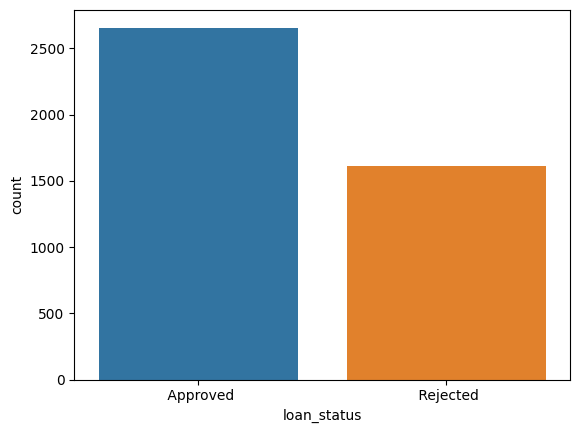

In [7]:
import seaborn as sns
sns.countplot(x='loan_status', data=df)

# Feature engineering

In [8]:
df['immovable_assets'] =  df['commercial_assets_value'] + df['residential_assets_value']
df['movable_assets'] = df['bank_asset_value'] + df['luxury_assets_value']
col = ['commercial_assets_value','residential_assets_value','bank_asset_value','luxury_assets_value']
df.drop(col, axis=1, inplace=True)

<Axes: xlabel='loan_amount', ylabel='Density'>

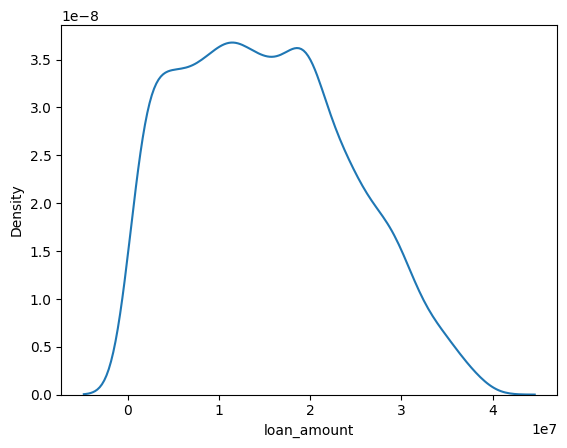

In [9]:
# Distribution Of Loan_amount column

import seaborn as sns
sns.kdeplot(data=df, x='loan_amount')

# distribution

<Axes: xlabel='loan_amount'>

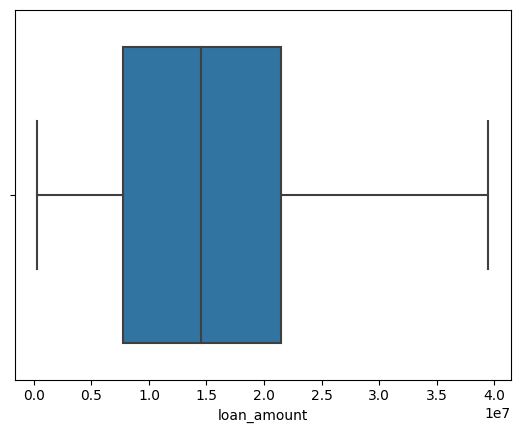

In [10]:
# checking the outliers

import seaborn as sns
sns.boxplot(data=df, x='loan_amount')

In [11]:
# Calculating the outliers using inter_quartile_range

def detect_outliers(x):
  Q1 = x.quantile(0.25)
  Q3 = x.quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5*IQR
  upper = Q3 + 1.5*IQR
  upper_array = np.where(x>=upper)[0]
  lower_array = np.where(x<=lower)[0]
  return upper_array, lower_array

In [12]:
detect_outliers(df['loan_amount'])

(array([], dtype=int64), array([], dtype=int64))

# Label encoding for categorical variables

In [13]:
print(df['education'].unique())
print(df['self_employed'].unique())
print(df['loan_status'].unique())
df['education'] = df['education'].str.strip()
df['self_employed'] = df['self_employed'].str.strip()
df['loan_status'] = df['loan_status'].str.strip()

[' Graduate' ' Not Graduate']
[' No' ' Yes']
[' Approved' ' Rejected']


In [14]:
education_mapping = {'Graduate': 1, 'Not Graduate': 0}
self_employed_mapping = {'Yes': 1, 'No': 0}
loan_status_mapping = {'Approved': 1, 'Rejected': 0}

# Apply label encoding using replace()
df['education'] = df['education'].replace(education_mapping)
df['self_employed'] = df['self_employed'].replace(self_employed_mapping)
df['loan_status'] = df['loan_status'].replace(loan_status_mapping)

# Split the data into training and testing sets

In [15]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train , y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Apply Yeo-Johnson transformation to selected columns

In [16]:
from sklearn.preprocessing import PowerTransformer

yeo_johnson_transformer = PowerTransformer(method="yeo-johnson")
X_train['immovable_assets'] = yeo_johnson_transformer.fit_transform(X_train[['immovable_assets']])
X_test['immovable_assets'] = yeo_johnson_transformer.transform(X_test[['immovable_assets']])
X_train['movable_assets'] = yeo_johnson_transformer.fit_transform(X_train[['movable_assets']])
X_test['movable_assets'] = yeo_johnson_transformer.transform(X_test[['movable_assets']])

# Standardize selected columns

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

col = ['income_annum','loan_amount','cibil_score']
X_train[col]=scaler.fit_transform(X_train[col])
X_test[col]=scaler.transform(X_test[col])

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

In [20]:
print(accuracy_score(y_test, y_pred))

0.905152224824356


In [21]:
print(f'The Classification report for logistic regression is {classification_report(y_test, y_pred)}')

The Classification report for logistic regression is               precision    recall  f1-score   support

           0       0.88      0.86      0.87       318
           1       0.92      0.93      0.92       536

    accuracy                           0.91       854
   macro avg       0.90      0.90      0.90       854
weighted avg       0.90      0.91      0.90       854



In [22]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LR, X_train, y_train, cv=5)
np.mean(scores)

0.9168374816983895

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators= 70,
 min_samples_split= 8,
 min_samples_leaf= 1,
 max_depth= 20,
 criterion= 'gini',
 bootstrap= False)
model.fit(X_train,y_train)
y_pred_rfc = model.predict(X_test)
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       318
           1       0.98      0.99      0.98       536

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [24]:
scores = cross_val_score(model, X_train, y_train, cv=5)
np.mean(scores)

0.9830161054172766

# RandomiedSearchCV

In [25]:
from sklearn.model_selection import RandomizedSearchCV
param = { "n_estimators": np.arange(10, 200, 10),
    "max_depth": [None] + list(np.arange(5, 30, 5)),
    "min_samples_split": np.arange(2, 11),
    "min_samples_leaf": np.arange(1, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(
    model, param_distributions=param, n_iter=100, cv=5, n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(bootstrap=False,
                                                    max_depth=20,
                                                    min_samples_split=8,
                                                    n_estimators=70),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 10, 15, 20, 25],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   random_state=42)

In [26]:
print(f'The best parameters for random forest is {random_search.best_params_}')

The best parameters for random forest is {'n_estimators': 70, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}


In [27]:
print(f'The best score {random_search.best_score_}')

The best score 0.9830161054172768


# Applying Decision Tree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
print(classification_report(y_test,y_pred_dtc))
scores = cross_val_score(dtc, X, y, cv=5)
print(np.mean(scores))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       318
           1       0.98      0.99      0.99       536

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

0.9789161274026649


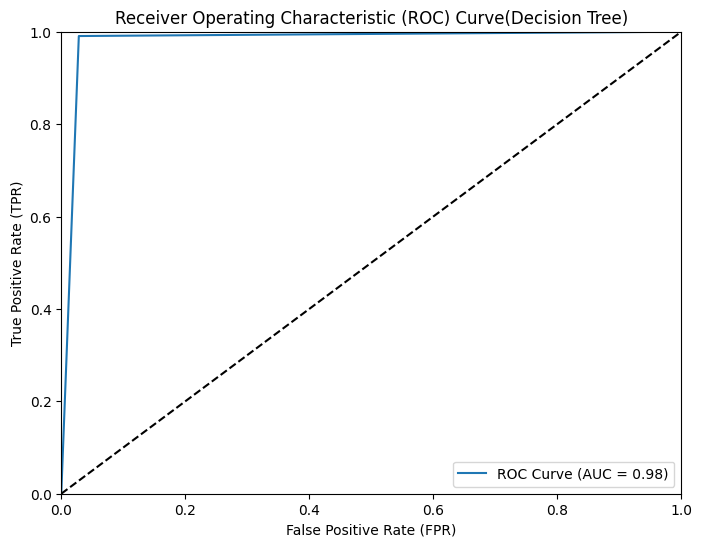

the roc_auc score (for decision tree) is 0.981184877499296


In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_pred_proba = dtc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve(Decision Tree)')
plt.legend(loc="lower right")
plt.show()

print(f'the roc_auc score (for decision tree) is {roc_auc}')

#### ROC-AUC score of approximately 0.978, the Decision Tree model is doing an excellent job of distinguishing between the positive and negative classes. It suggests that the model has a high true positive rate and a low false positive rate across different threshold settings, which is a strong indicator of its classification performance.

# Applying GradientBoosting Classifier

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
grad =GradientBoostingClassifier()
grad.fit(X_train,y_train)
y_pred_grad = grad.predict(X_test)
print(f'GradientBoosting {classification_report(y_test, y_pred_grad)}')
scores = cross_val_score(grad, X, y, cv=5)
print(np.mean(scores))

GradientBoosting               precision    recall  f1-score   support

           0       0.98      0.95      0.96       318
           1       0.97      0.99      0.98       536

    accuracy                           0.97       854
   macro avg       0.97      0.97      0.97       854
weighted avg       0.97      0.97      0.97       854

0.9798528955525476


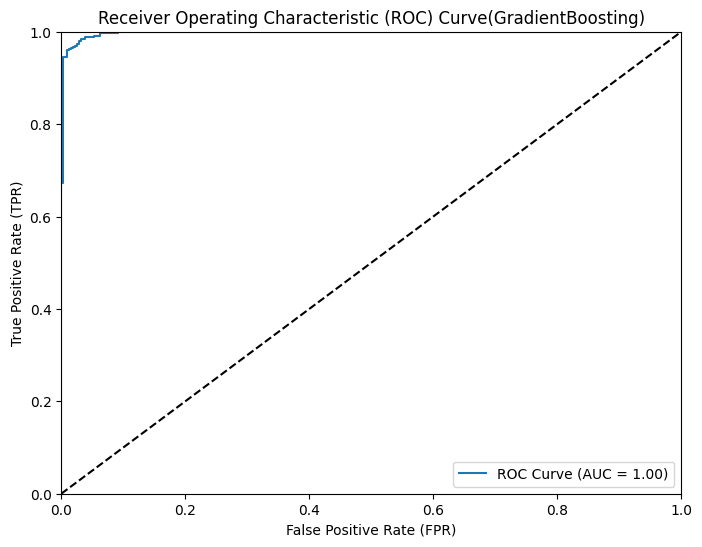

the roc_auc score (for gradientBoosting) is 0.9975183047029006


In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_pred_proba = grad.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve(GradientBoosting)')
plt.legend(loc="lower right")
plt.show()

print(f'the roc_auc score (for gradientBoosting) is {roc_auc}')

### ROC-AUC score of approximately 0.997, the GradientBoosting model is doing even better than Decision Tree of distinguishing between the positive and negative classes. It suggests that the model has a high true positive rate and a low false positive rate across different threshold settings, which is a strong indicator of its classification performance.

# Final Conclusion

## In terms of ROC-AUC, Gradient Boosting outperforms the Decision Tree with a higher score of approximately 0.9975 compared to 0.9781. However, the Decision Tree has a slightly higher accuracy of 0.98, while Gradient Boosting has an accuracy of 0.97. Both models exhibit strong precision, recall, and F1-scores. The choice between them should consider the importance of ROC-AUC for class separation and the slight accuracy advantage of the Decision Tree. 